In [148]:
import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [321]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139969, 0.48215842, 0.44653093], [0.20220212, 0.19931542, 0.20086347])
])
training_data = CIFAR10('cifar/train', train=True, download=True, transform=transform)
test_data = CIFAR10('cifar/test', train=False, download=True, transform=transform)
loader = DataLoader(training_data, 32, True)
loader_test = DataLoader(test_data, 32)

Files already downloaded and verified
Files already downloaded and verified


In [322]:
#calculate dataset mean and std per channel to feed to transform normalization params
def calc_normalize_values():
    means = np.zeros(3)
    stds = np.zeros(3)
    N = len(training_data)
    for i, (data, label) in enumerate(training_data):
        means += data.numpy().mean(axis=(1,2))
        stds += data.numpy().std(axis=(1,2))
    means /= N
    stds /= N
    print(means, stds)
calc_normalize_values()

KeyboardInterrupt: 

In [323]:
(data, labels) = next(iter(loader))
print(data.shape)

torch.Size([32, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


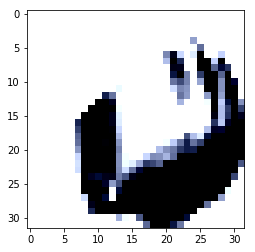

In [331]:
im = data[5].numpy()
plt.imshow(im.T)

In [332]:
target[5].numpy()


array(5)

In [326]:
p={}
p['W1'] = torch.randn(32, 3, 5, 5, dtype=torch.float32) * np.sqrt(2. / 3 * 5 * 5)
p['W1'].requires_grad = True
p['b1'] = torch.zeros(32, dtype=torch.float32, requires_grad=True)
p['W2'] = torch.randn(16, 32, 5, 5, dtype=torch.float32) * np.sqrt(2. / 32 * 5 * 5)
p['W2'].requires_grad = True
p['b2'] = torch.zeros(16, dtype=torch.float32, requires_grad=True)
p['W3'] = torch.randn(16*32*32, 10, dtype=torch.float32) * np.sqrt(2. / 16 * 32 * 32)
p['W3'].requires_grad = True
p['b3'] = torch.zeros(10, dtype=torch.float32, requires_grad=True)

In [327]:
def convnet(x, params):
    a1 = F.conv2d(x, weight=params['W1'], bias=params['b1'], padding=2)
    z1 = a1.clamp(0)
    a2 = F.conv2d(z1, weight=params['W2'], bias=params['b2'], padding=2)
    z2 = a2.clamp(0)
    z2 = z2.view(z2.shape[0], -1)
    a3 = z2.mm(params['W3']) + params['b3']
    return a3

#scores = convnet(data, p)
#loss = torch.nn.CrossEntropyLoss()
#cost = loss(scores, labels)
#cost.backward()

In [328]:
len(loader_test.dataset)/32

312.5

In [329]:
def check_accuracy():
    acc = 0
    num_samples = 0
    for i, (data, labels) in enumerate(loader_test):
        scores = convnet(data, p)
        res = scores.argmax(dim=1)
        correct = res == labels
        acc += correct.sum().float()/labels.shape[0]
        num_samples += 1
    acc /= num_samples
    return float(acc)

In [330]:
for idx, (data, labels) in enumerate(loader):
    scores = convnet(data, p)
    cost = F.cross_entropy(scores, labels)
    cost.backward()
    with torch.no_grad():
        for k,w in p.items():
            w -= 3e-3 * w.grad
            w.grad.zero_()
    if idx % 100 == 0:
        print('iteration %d, cost is %f, test accuracy is %f' % (idx, float(cost), check_accuracy()))

iteration 0, cost is 1124151.375000, test accuracy is 0.114217
iteration 100, cost is nan, test accuracy is 0.100040
iteration 200, cost is nan, test accuracy is 0.100040


KeyboardInterrupt: 

In [285]:
a=(2,3,4)
2./a[1:]

TypeError: unsupported operand type(s) for /: 'float' and 'tuple'